In [91]:
import numpy as np
from numpy.random import rand
import pandas as pd 
from pandas import Series, DataFrame

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sb

import statsmodels.api as sm
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric import smoothers_lowess
from patsy import dmatrices
from sklearn import datasets, svm

In [92]:
%matplotlib inline
rcParams['figure.figsize'] = 5, 4
sb.set_style('whitegrid')

In [93]:
# read csv data
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [94]:
df_train.shape, df_test.shape

((891, 12), (418, 11))

### Descriptive Statistics

In [95]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [96]:
df_test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


Based on the statistics above in the __training set__, we know that about 38% people survived.

### Exploratory Data Analysis (EDA)

Lets visualize  some of the variables within the training data set to get a better understanding of the data.

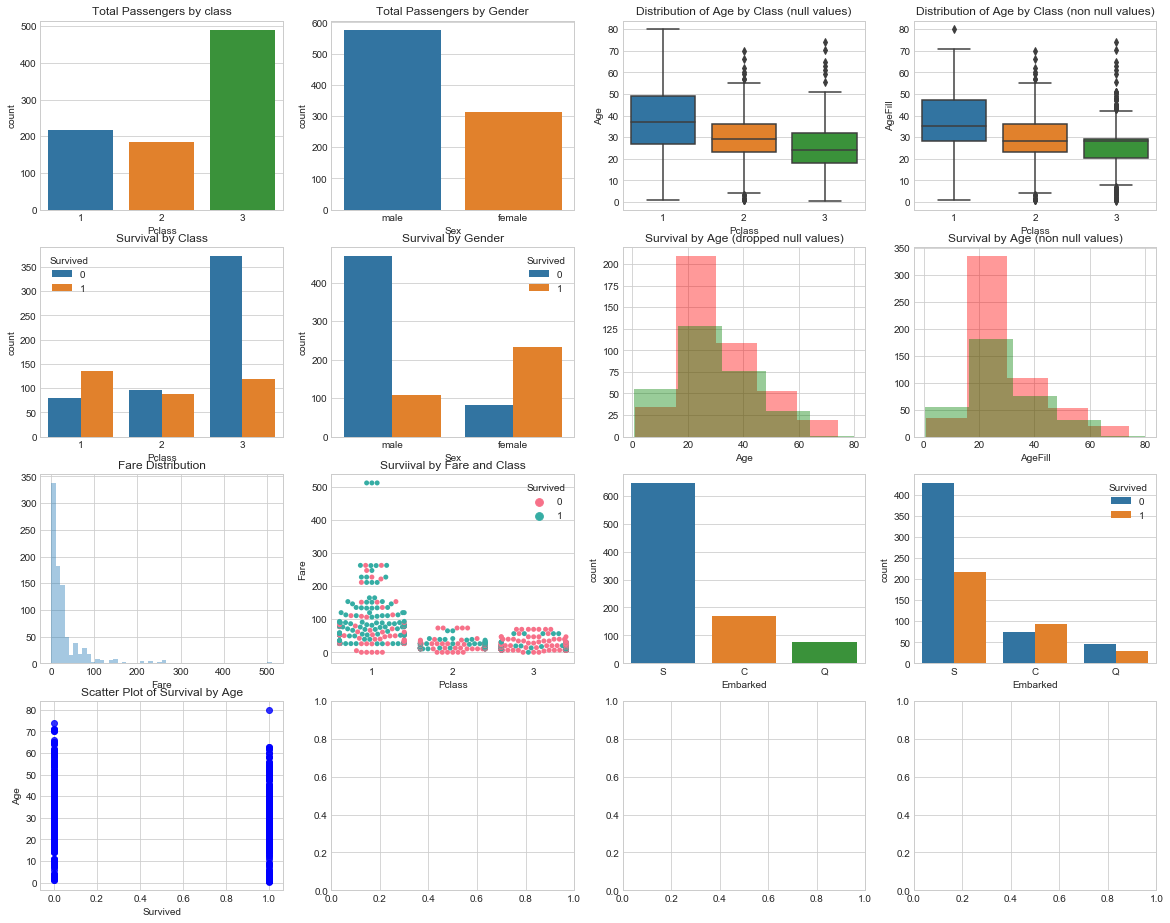

In [97]:
fig,axs = plt.subplots(4,4,figsize=(20,16))

# passengers count by class
sb.countplot('Pclass', data=df_train, ax=axs[0,0])
axs[0,0].set_title('Total Passengers by class')

# passengets count by gender
sb.countplot('Sex', data=df_train, ax=axs[0,1])
axs[0,1].set_title('Total Passengers by Gender')

# a box plot of passenger ages by age
sb.boxplot(x='Pclass', y='Age', data=df_train, ax=axs[0,2])
axs[0,2].set_title('Distribution of Age by Class (null values)')

# age has NaN values, fill this with mean or median
median_age = df_train.Age.median()
median_age = round(median_age, 0)
df_train['AgeFill'] = df_train.Age.fillna(value=median_age)
df_test['AgeFill'] = df_test.Age.fillna(value=median_age)
sb.boxplot(x='Pclass', y='AgeFill', data=df_train, ax=axs[0,3])
ax=axs[0,3].set_title('Distribution of Age by Class (non null values)')

# survival by class
sb.countplot('Pclass', hue='Survived', data=df_train, ax=axs[1,0])
axs[1,0].set_title("Survival by Class")

# survival by gender
sb.countplot('Sex', hue='Survived', data=df_train, ax=axs[1,1])
axs[1,1].set_title("Survival by Gender")

# Age distribution
sb.distplot(df_train[df_train['Survived']==0]['Age'].dropna(), ax=axs[1,2], kde=False, color='r',bins=5)
sb.distplot(df_train[df_train['Survived']==1]['Age'].dropna(), ax=axs[1,2], kde=False, color='g',bins=5)
axs[1,2].set_title("Survival by Age (dropped null values)")

sb.distplot(df_train[df_train['Survived']==0]['AgeFill'], ax=axs[1,3], kde=False, color='r',bins=5)
sb.distplot(df_train[df_train['Survived']==1]['AgeFill'], ax=axs[1,3], kde=False, color='g',bins=5)
axs[1,3].set_title("Survival by Age (non null values)")

# fare distribution
sb.distplot(df_train['Fare'], ax=axs[2,0], kde=False)
axs[2,0].set_title("Fare Distribution")

# survival by fare and class
sb.swarmplot(x='Pclass',y='Fare',hue='Survived',data=df_train,palette='husl',ax=axs[2,1])
axs[2,1].set_title("Surviival by Fare and Class")

sb.regplot(x=df_train['Survived'], y=df_train['Age'], color='blue', fit_reg=None, ax=axs[3,0])
axs[3,0].set_title("Scatter Plot of Survival by Age")

sb.countplot('Embarked', data=df_train, ax=axs[2,2])
sb.countplot('Embarked', hue='Survived', data=df_train, ax=axs[2,3])

### What we learned from exploring the data
* There were mostly class 3 passengers.
* There were more male passengers than female. 
* Older people are generally first class and lower class are younger. 
* Mostly people from class 3 did not survive. 
* Females in general survived more
* Mostly people between age 20-40 died, meaning younger people and older people had higher chance of survival. 
* Most people paid a fare of 100 or less.
* People who paid for the first class fare had a higher chance of survival.
* Most people boarded at Southampton

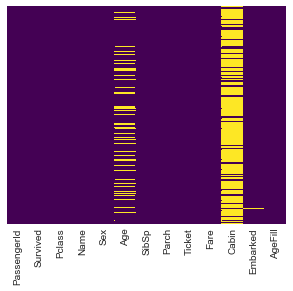

In [98]:
sb.heatmap(df_train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [99]:
df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
AgeFill          0
dtype: int64

Based on the code above, both Age and Cabin have NaN values. We will use `AgeFill` instead of `Age` for our training variable.

In [100]:
df_test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
AgeFill          0
dtype: int64

### Preparing Predictors and Predictant

In [101]:
from sklearn.linear_model import LogisticRegression

In [102]:
cols=["Pclass","Sex","AgeFill"]

df_test['Sex'] = df_test['Sex'].apply(lambda sex:1 if sex=='male' else 0)
df_train['Sex'] = df_train['Sex'].apply(lambda sex:1 if sex=='male' else 0)
df_test['Fare'] = df_test['Fare'].fillna(df_test['Fare'].mean())
df_train_survived = df_train['Survived'].values
data_train = df_train[cols].values
data_test = df_test[cols].values

### Checking Correlation

In [103]:
# check correlation between pclass, sex, and AgeFill
print(df_train.corr())

             PassengerId  Survived    Pclass       Sex       Age     SibSp  \
PassengerId     1.000000 -0.005007 -0.035144  0.042939  0.036847 -0.057527   
Survived       -0.005007  1.000000 -0.338481 -0.543351 -0.077221 -0.035322   
Pclass         -0.035144 -0.338481  1.000000  0.131900 -0.369226  0.083081   
Sex             0.042939 -0.543351  0.131900  1.000000  0.093254 -0.114631   
Age             0.036847 -0.077221 -0.369226  0.093254  1.000000 -0.308247   
SibSp          -0.057527 -0.035322  0.083081 -0.114631 -0.308247  1.000000   
Parch          -0.001652  0.081629  0.018443 -0.245489 -0.189119  0.414838   
Fare            0.012658  0.257307 -0.549500 -0.182333  0.096067  0.159651   
AgeFill         0.034212 -0.064910 -0.339898  0.081163  1.000000 -0.233296   

                Parch      Fare   AgeFill  
PassengerId -0.001652  0.012658  0.034212  
Survived     0.081629  0.257307 -0.064910  
Pclass       0.018443 -0.549500 -0.339898  
Sex         -0.245489 -0.182333  0.081163  

The correlation between Pclass, Sex, and AgeFill is close to 0. This means there is no significant negative (close to -1) or positive (close to 1) correlation. A close to 0 correclation indicate that these variables are independent of each other. 

### Applying Logistic Regression

In [104]:
# Logistic Regression
logReg = LogisticRegression()

# pass in features and target 
logReg.fit(data_train, df_train_survived)

# predict with data set containg features and no target variable 'survived'
predict = logReg.predict(data_test)

# evaluate score
score = logReg.score(data_train, df_train_survived)
print(score)

0.7968574635241302


The model's score is 79%, which is not that bad. We had to fill in 86 missing values for the Age column. We can definitely increase the model's score by trying another machine learning algorithm. 

In [105]:
df_test['Survived'] = predict
df_test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeFill,Survived
0,892,3,"Kelly, Mr. James",1,34.5,0,0,330911,7.8292,NaN,Q,34.5,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",0,47.0,1,0,363272,7.0000,NaN,S,47.0,0
2,894,2,"Myles, Mr. Thomas Francis",1,62.0,0,0,240276,9.6875,NaN,Q,62.0,0
3,895,3,"Wirz, Mr. Albert",1,27.0,0,0,315154,8.6625,NaN,S,27.0,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,22.0,1,1,3101298,12.2875,NaN,S,22.0,1
5,897,3,"Svensson, Mr. Johan Cervin",1,14.0,0,0,7538,9.2250,NaN,S,14.0,0
6,898,3,"Connolly, Miss. Kate",0,30.0,0,0,330972,7.6292,NaN,Q,30.0,1
7,899,2,"Caldwell, Mr. Albert Francis",1,26.0,1,1,248738,29.0000,NaN,S,26.0,0
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",0,18.0,0,0,2657,7.2292,NaN,C,18.0,1
9,901,3,"Davies, Mr. John Samuel",1,21.0,2,0,A/4 48871,24.1500,NaN,S,21.0,0


In [106]:
df_test.shape

(418, 13)

In [107]:
final = df_test[['PassengerId', 'Survived']]
final

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


### Exporting Results

In [108]:
final.to_csv("survivial_predictions.csv", sep=',', index=False)